# U-net For Image Restoration

This tutorial demonstrates the usage of a U-net model for image restoration after lossy JPEG compression

The goals of this tutorial are:
  - Introduce how to implement the U-net model using Keras and TensorFlow.
  - Illustrate the usage of the U-net model in an image-to-image regression problem.
  
Tutorial data download:
  - [GDrive](https://drive.google.com/file/d/1iGqIsjGgSu4qwL466qXgotxs8KRh4U3g/view?usp=sharing)
  - [OneDrive](https://uofc-my.sharepoint.com/:u:/g/personal/roberto_medeirosdeso_ucalgary_ca/ETz4IZiZHzVEtimvKvGRjRYBQNmevhdqBEOT03cD_q2Ycg?e=7fJLrm) - This link expires February 27th, 2021.
  
      
## Importing Python Libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

# Comment this lines in your computers or Google COLAB
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data Augmentation - Flow from Directory

When you do not have enough memory to load your entire dataset, you can use flor from directory to load your batches of data on the fly during training.

In [2]:
seed = 909 # (IMPORTANT) to input image and corresponding target with same augmentation parameter.

gen_params = {"rescale":1.0/255,"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}

train_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params) 

train_target_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params) 

train_image_generator = train_image_datagen.flow_from_directory("/media/roberto/f5da97cf-b92d-484c-96e9-15766931cebe/JPEG-compression/Data/Compressed/Train-root/",
                                                    class_mode=None, batch_size = 2,seed=seed, target_size=(288, 512),color_mode='rgb',shuffle = True)

train_target_generator = train_target_datagen.flow_from_directory("/media/roberto/f5da97cf-b92d-484c-96e9-15766931cebe/JPEG-compression/Data/Uncompressed/Train-root/",
                                                    class_mode=None, batch_size = 2, seed=seed, target_size=(288, 512),color_mode='rgb' ,shuffle = True)

train_generator = zip(train_image_generator, train_target_generator)

val_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params) 

val_target_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params) 

val_image_generator = val_image_datagen.flow_from_directory("/media/roberto/f5da97cf-b92d-484c-96e9-15766931cebe/JPEG-compression/Data/Compressed/Val-root/",
                                                     class_mode=None, batch_size = 2,seed=seed, target_size=(288, 512),color_mode='rgb',shuffle = True)

val_target_generator = val_target_datagen.flow_from_directory("/media/roberto/f5da97cf-b92d-484c-96e9-15766931cebe/JPEG-compression/Data/Uncompressed/Val-root/",
                                                    class_mode=None, batch_size = 2, seed=seed, target_size=(288, 512),color_mode='rgb' ,shuffle = True)


val_generator = zip(val_image_generator, val_target_generator)

Found 1999 images belonging to 1 classes.
Found 1999 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


## Displaying Some Images

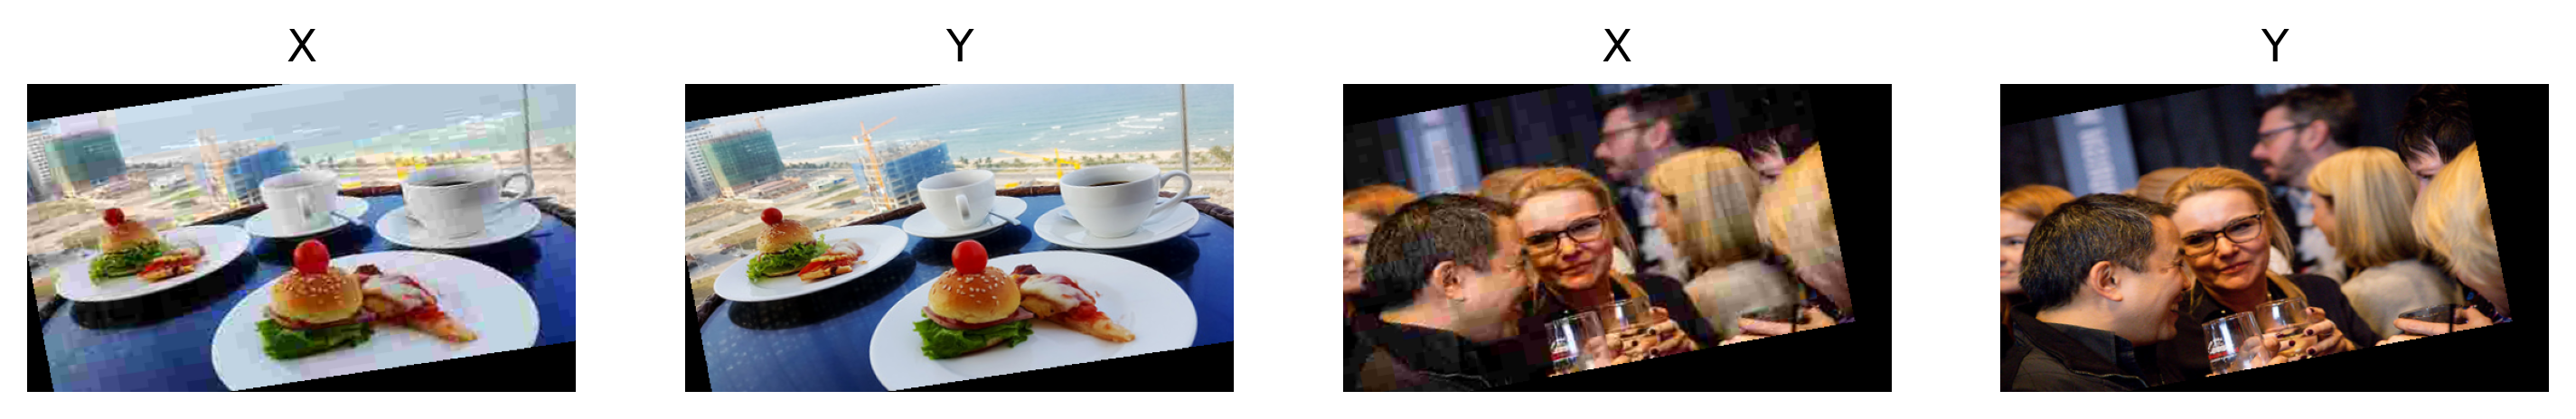

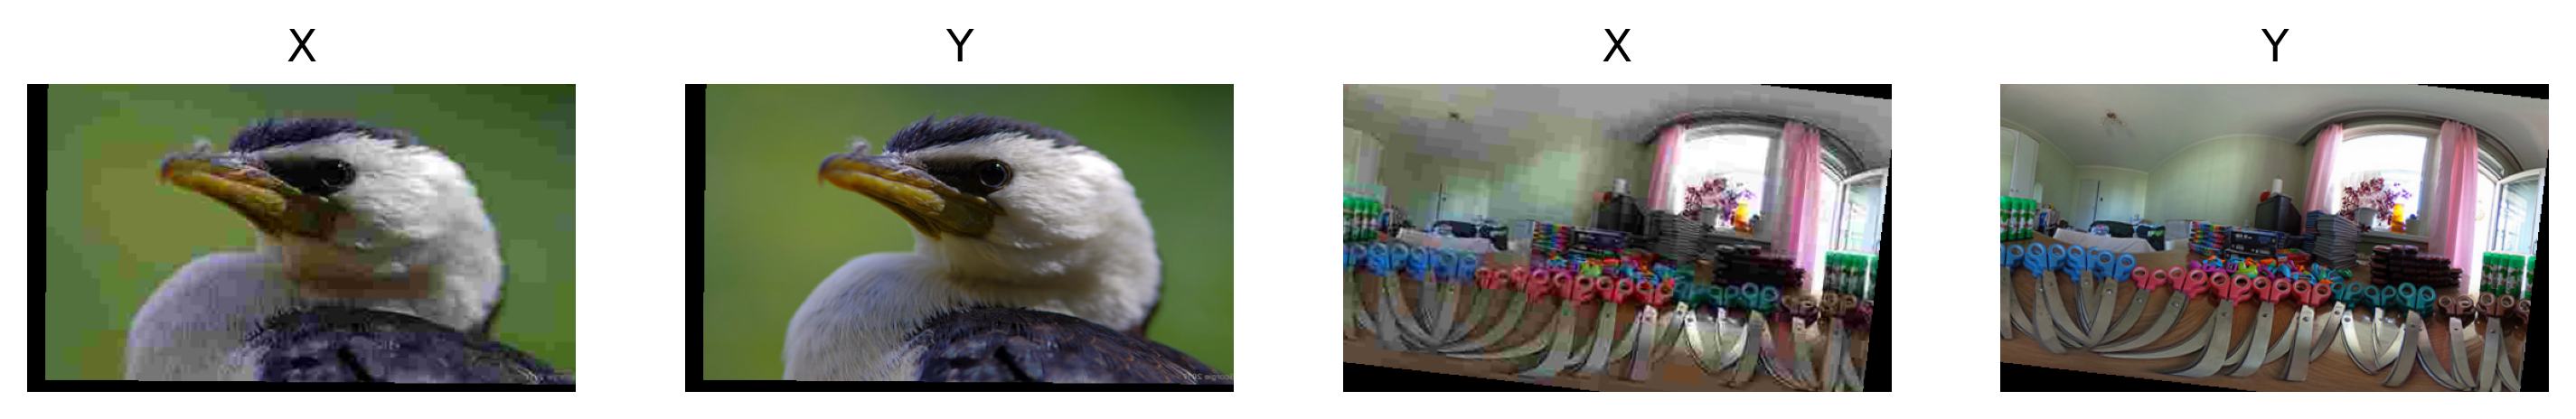

In [3]:
# Train set
for X,Y in train_generator:
  plt.figure(figsize = (12,18), dpi = 300)
  for ii in range (2):
    plt.subplot(1,4,ii*2+1)
    plt.imshow(X[ii]/X[ii].max())
    plt.axis("off")
    plt.title("X")
    plt.subplot(1,4,ii*2+2)
    plt.imshow(Y[ii]/Y[ii].max())
    plt.axis("off")
    plt.title("Y")
  plt.show()
  break

# Validation set
for X,Y in val_generator:
  plt.figure(figsize = (12,18), dpi = 300)
  for ii in range (2):
    plt.subplot(1,4,ii*2+1)
    plt.imshow(X[ii]/X[ii].max())
    plt.axis("off")
    plt.title("X")
    plt.subplot(1,4,ii*2+2)
    plt.imshow(Y[ii]/Y[ii].max())
    plt.axis("off")
    plt.title("Y")
  plt.show()
  break

## Defining the U-net Model

In [4]:
def get_unet_mod(patch_size = (288,512),learning_rate = 1e-3,\
                 learning_decay = 1e-6, drop_out = 0.1,nchannels = 3,kshape = (3,3)):
    ''' Get U-Net model with gaussian noise and dropout'''
    
    dropout = drop_out
    
    input_img = tf.keras.layers.Input((patch_size[0], patch_size[1],nchannels))
    
    conv1 = tf.keras.layers.Conv2D(48, kshape, activation='relu', padding='same')(input_img)
    conv1 = tf.keras.layers.Conv2D(48, kshape, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(96, kshape, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(96, kshape, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = tf.keras.layers.Conv2D(192, kshape, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(192, kshape, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = tf.keras.layers.Conv2D(384, kshape, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(384, kshape, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(dropout)(pool4)

    conv5 = tf.keras.layers.Conv2D(768, kshape, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(768, kshape, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2))(conv5), conv4],axis=-1)
    up6 = tf.keras.layers.Dropout(dropout)(up6)
    conv6 = tf.keras.layers.Conv2D(384, kshape, activation='relu', padding='same')(up6)
    conv6 = tf.keras.layers.Conv2D(384, kshape, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2))(conv6), conv3],axis=-1)
    up7 = tf.keras.layers.Dropout(dropout)(up7)
    conv7 = tf.keras.layers.Conv2D(192, kshape, activation='relu', padding='same')(up7)
    conv7 = tf.keras.layers.Conv2D(192, kshape, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2))(conv7), conv2],axis=-1)
    up8 = tf.keras.layers.Dropout(dropout)(up8)
    conv8 = tf.keras.layers.Conv2D(96, kshape, activation='relu', padding='same')(up8)
    conv8 = tf.keras.layers.Conv2D(96, kshape, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    up9 = tf.keras.layers.Dropout(dropout)(up9)
    conv9 = tf.keras.layers.Conv2D(48, kshape, activation='relu', padding='same')(up9)
    conv9 = tf.keras.layers.Conv2D(48, kshape, activation='relu', padding='same')(conv9)

    conv10 = tf.keras.layers.Conv2D(3, (1, 1), activation='linear')(conv9)
    out = tf.keras.layers.Add()([conv10, input_img]) 
    model = tf.keras.models.Model(inputs=input_img, outputs=out)
    opt = tf.keras.optimizers.Adam(lr= learning_rate, decay = learning_decay)
    model.compile(optimizer= opt,loss='mse')

    return model

In [5]:
model = get_unet_mod()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 288, 512, 48) 1344        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 288, 512, 48) 20784       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 144, 256, 48) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Defining Callbacks

In [6]:
model_name = "unet_jpeg.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%3 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## Training the Model

In [7]:
history = model.fit(train_generator, steps_per_epoch=1000, validation_data = (val_generator),\
                    validation_steps = 500,\
                    epochs=15,verbose=1, callbacks = [early_stop, monitor, lr_schedule])

Epoch 1/15
1000/1000 [==============================] - 170s 170ms/step - loss: 0.0017 - val_loss: 0.0016 - lr: 0.0010
Epoch 2/15
1000/1000 [==============================] - 171s 171ms/step - loss: 0.0016 - val_loss: 0.0015 - lr: 0.0010
Epoch 3/15
1000/1000 [==============================] - 173s 173ms/step - loss: 0.0015 - val_loss: 0.0015 - lr: 0.0010
Epoch 4/15
1000/1000 [==============================] - 174s 174ms/step - loss: 0.0015 - val_loss: 0.0015 - lr: 5.0000e-04
Epoch 5/15
1000/1000 [==============================] - 175s 175ms/step - loss: 0.0015 - val_loss: 0.0014 - lr: 5.0000e-04
Epoch 6/15
1000/1000 [==============================] - 176s 176ms/step - loss: 0.0015 - val_loss: 0.0014 - lr: 5.0000e-04
Epoch 7/15
1000/1000 [==============================] - 178s 178ms/step - loss: 0.0014 - val_loss: 0.0014 - lr: 2.5000e-04
Epoch 8/15
1000/1000 [==============================] - 179s 179ms/step - loss: 0.0014 - val_loss: 0.0014 - lr: 2.5000e-04
Epoch 9/15
1000/1000 [======

## Testing the model

In [11]:
import natsort
model = get_unet_mod(patch_size = (None,None))
model.load_weights(model_name)
test_compressed = np.array(glob.glob("/media/roberto/f5da97cf-b92d-484c-96e9-15766931cebe/JPEG-compression/Data/Compressed/Test-root/Test/*.jpg"))
test_uncompressed = np.array(glob.glob("/media/roberto/f5da97cf-b92d-484c-96e9-15766931cebe/JPEG-compression/Data/Uncompressed/Test-root/Test/*.png"))

test_compressed = natsort.natsorted(test_compressed)
test_uncompressed = natsort.natsorted(test_uncompressed)

X_test = np.zeros((100,256,256,3))
Y_test = np.zeros((100,256,256,3))

for ii in range(100):
    X_test[ii] = np.array(tf.keras.preprocessing.image.load_img(test_compressed[ii]))[:256,:256,:]/255.0
    Y_test[ii] = np.array(tf.keras.preprocessing.image.load_img(test_uncompressed[ii]))[:256,:256,:]/255.0
    
Ypred = np.clip(model.predict(X_test,batch_size = 2),0,1)

In [12]:
MSE1 = ((Ypred - Y_test)**2).mean()
MSE2 = ((X_test - Y_test)**2).mean()
print("UNET MSE:")
print(MSE1)
print("JPEG MSE:")
print(MSE2)

UNET MSE:
0.002595744039795968
JPEG MSE:
0.003482420249585991


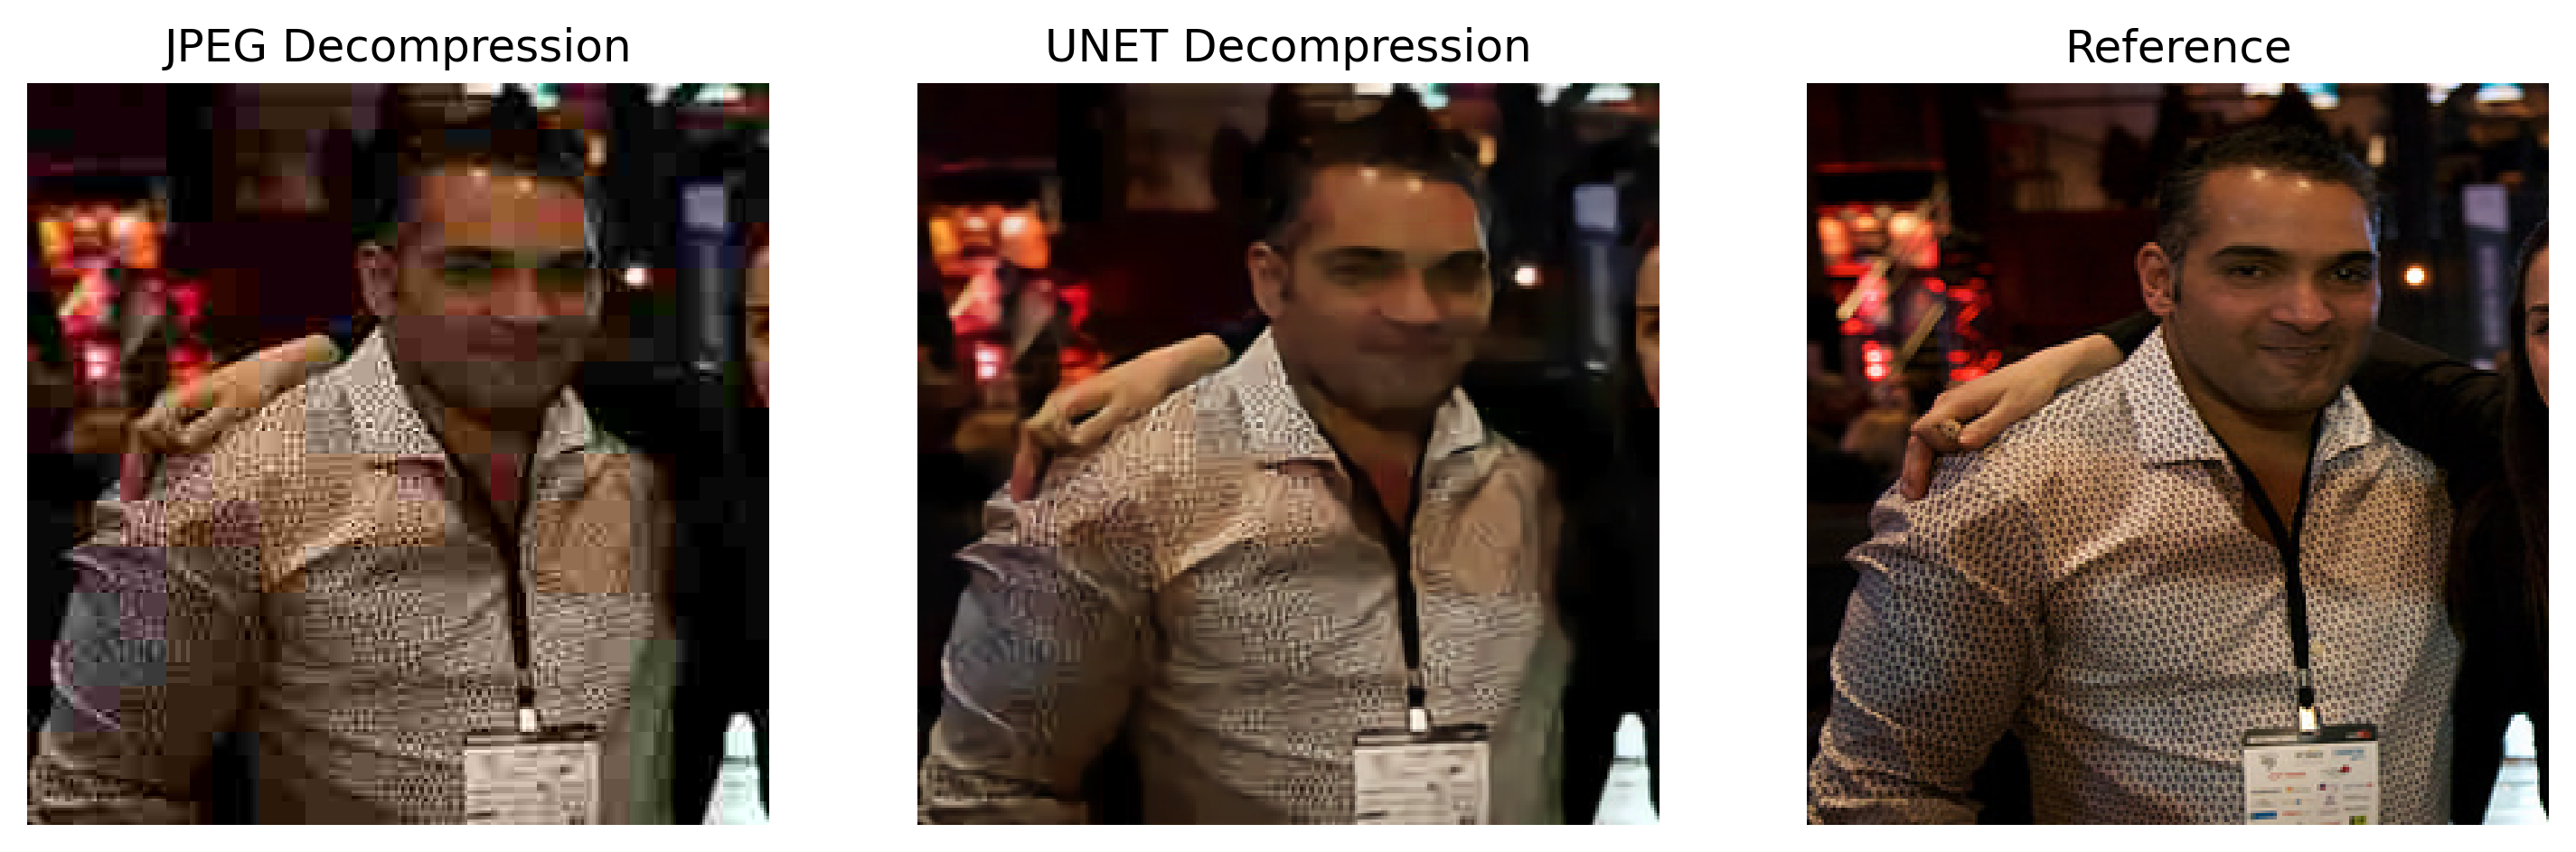

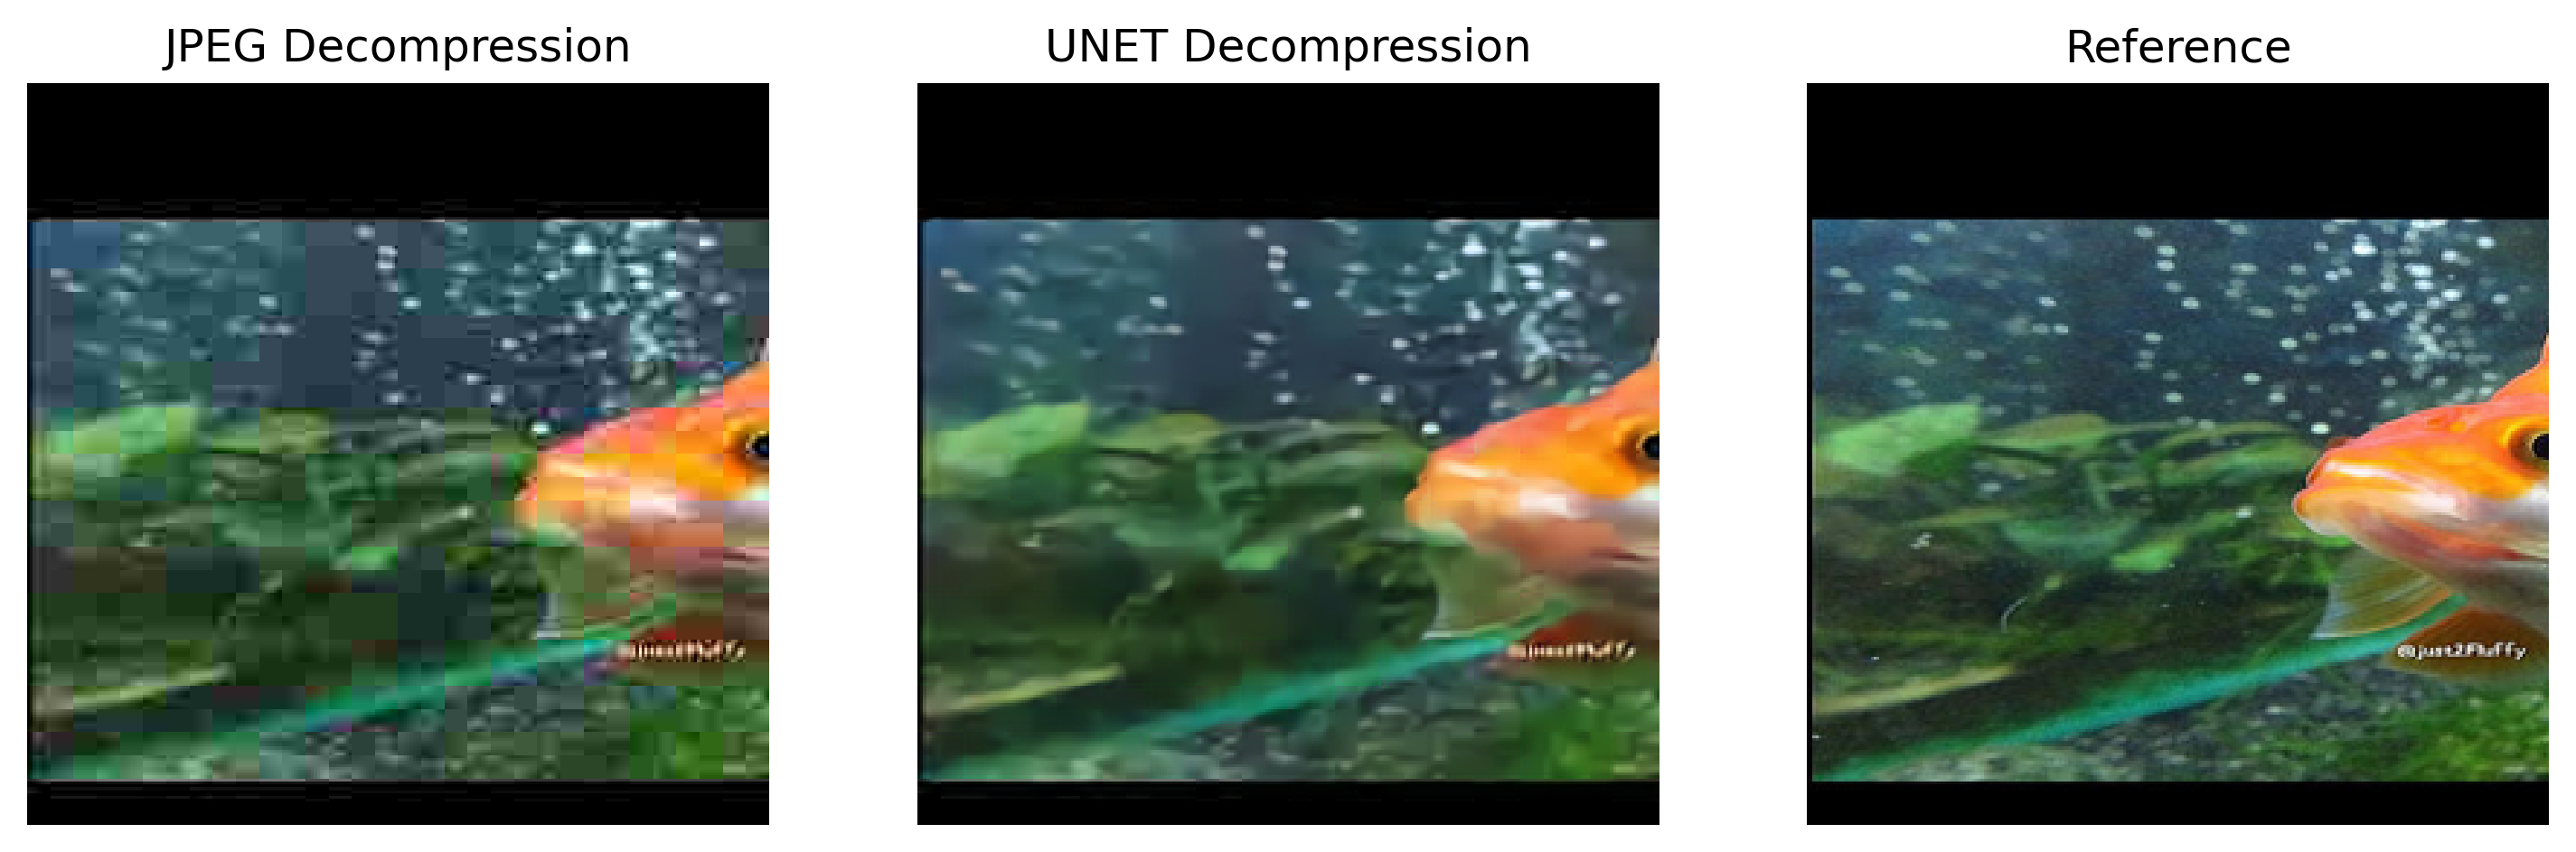

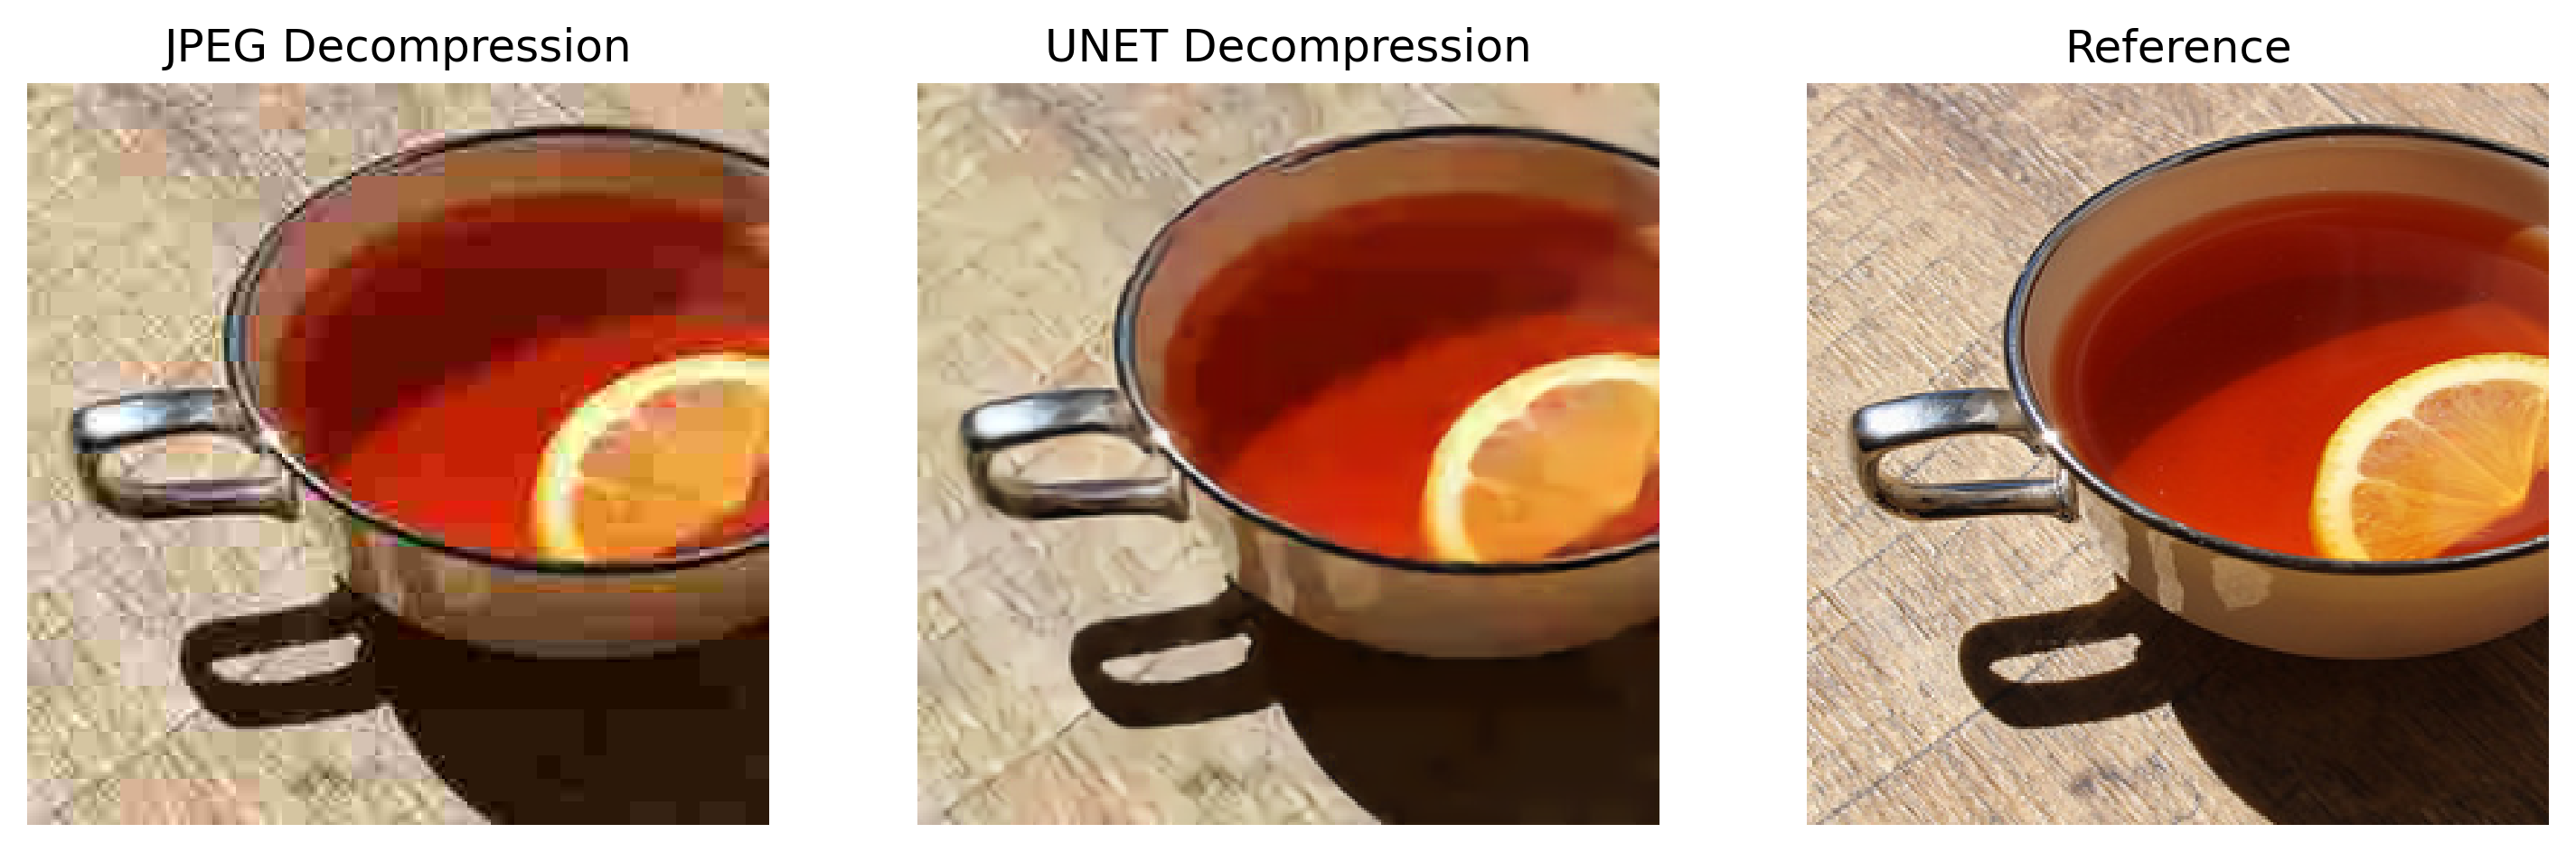

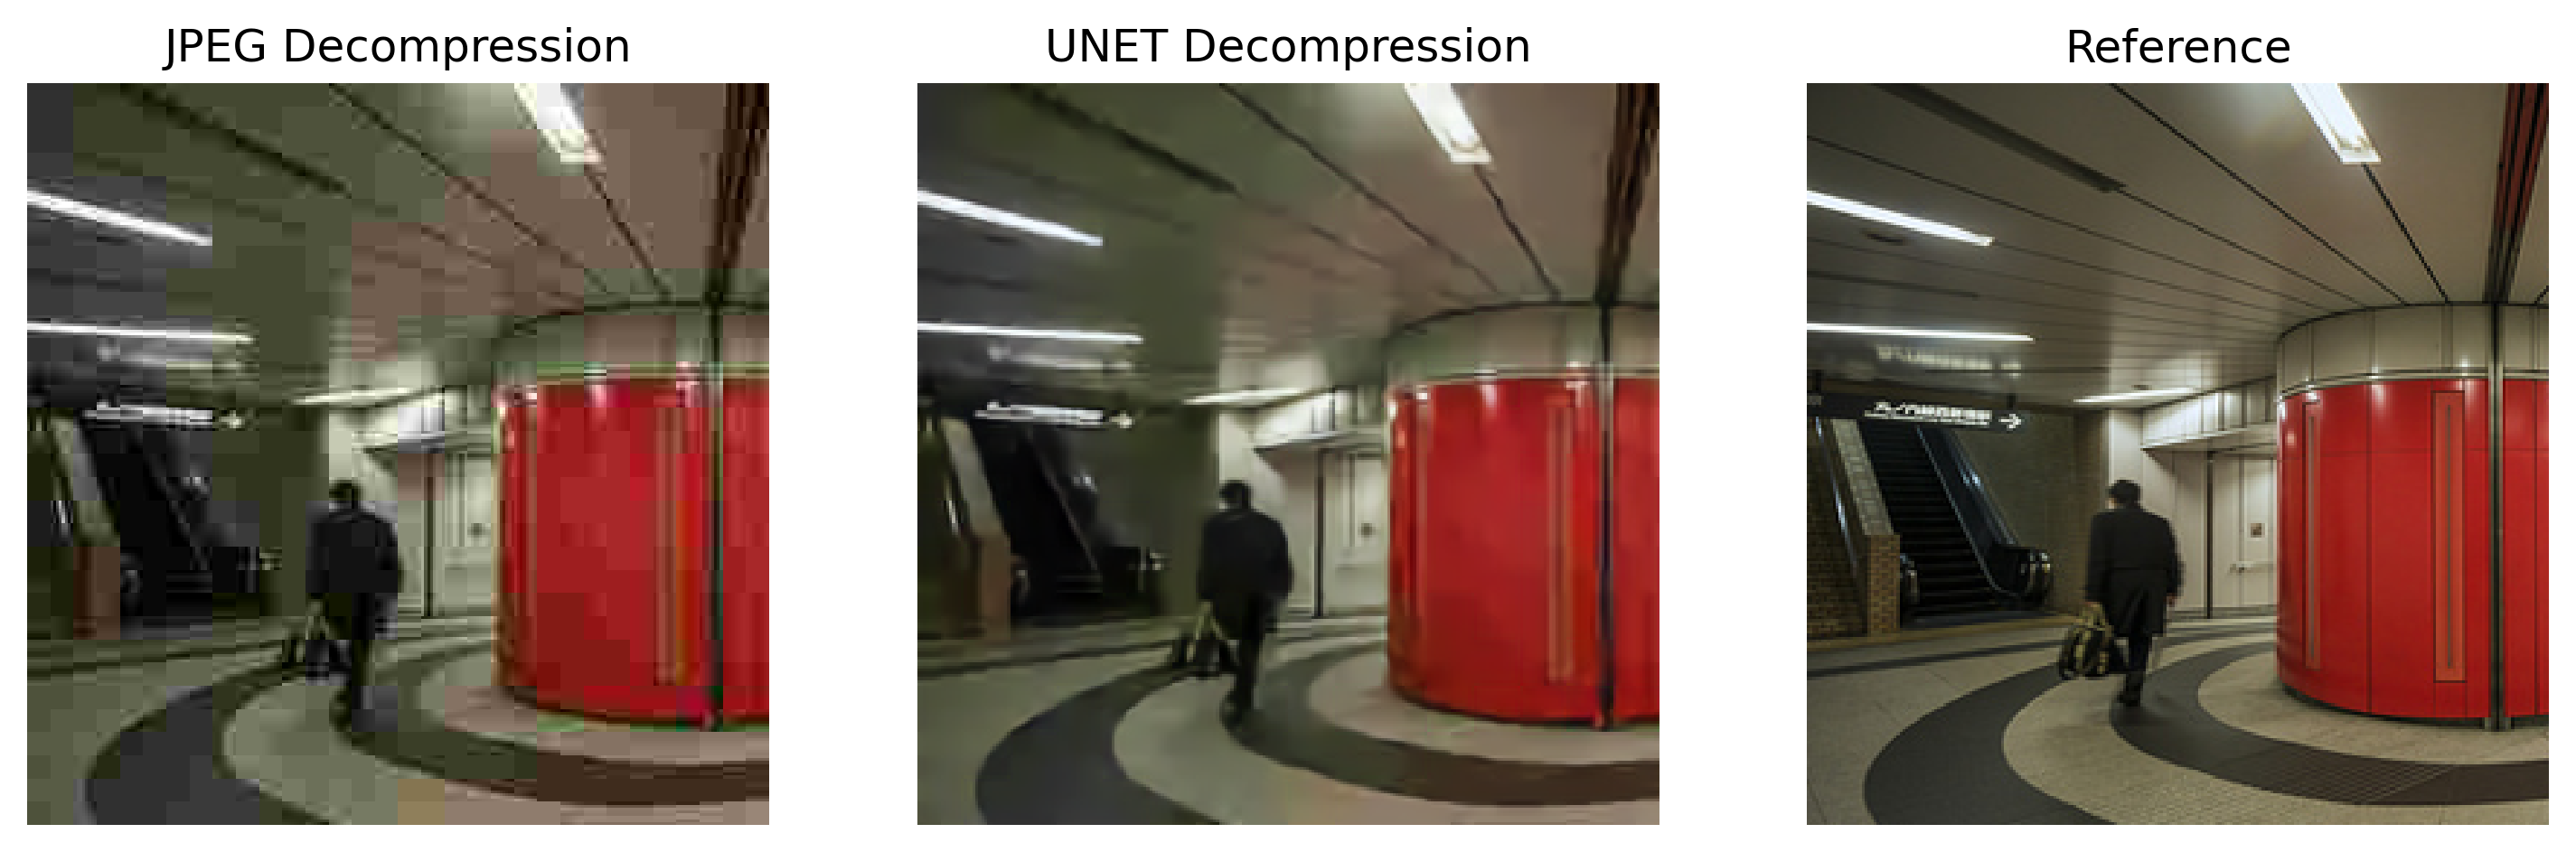

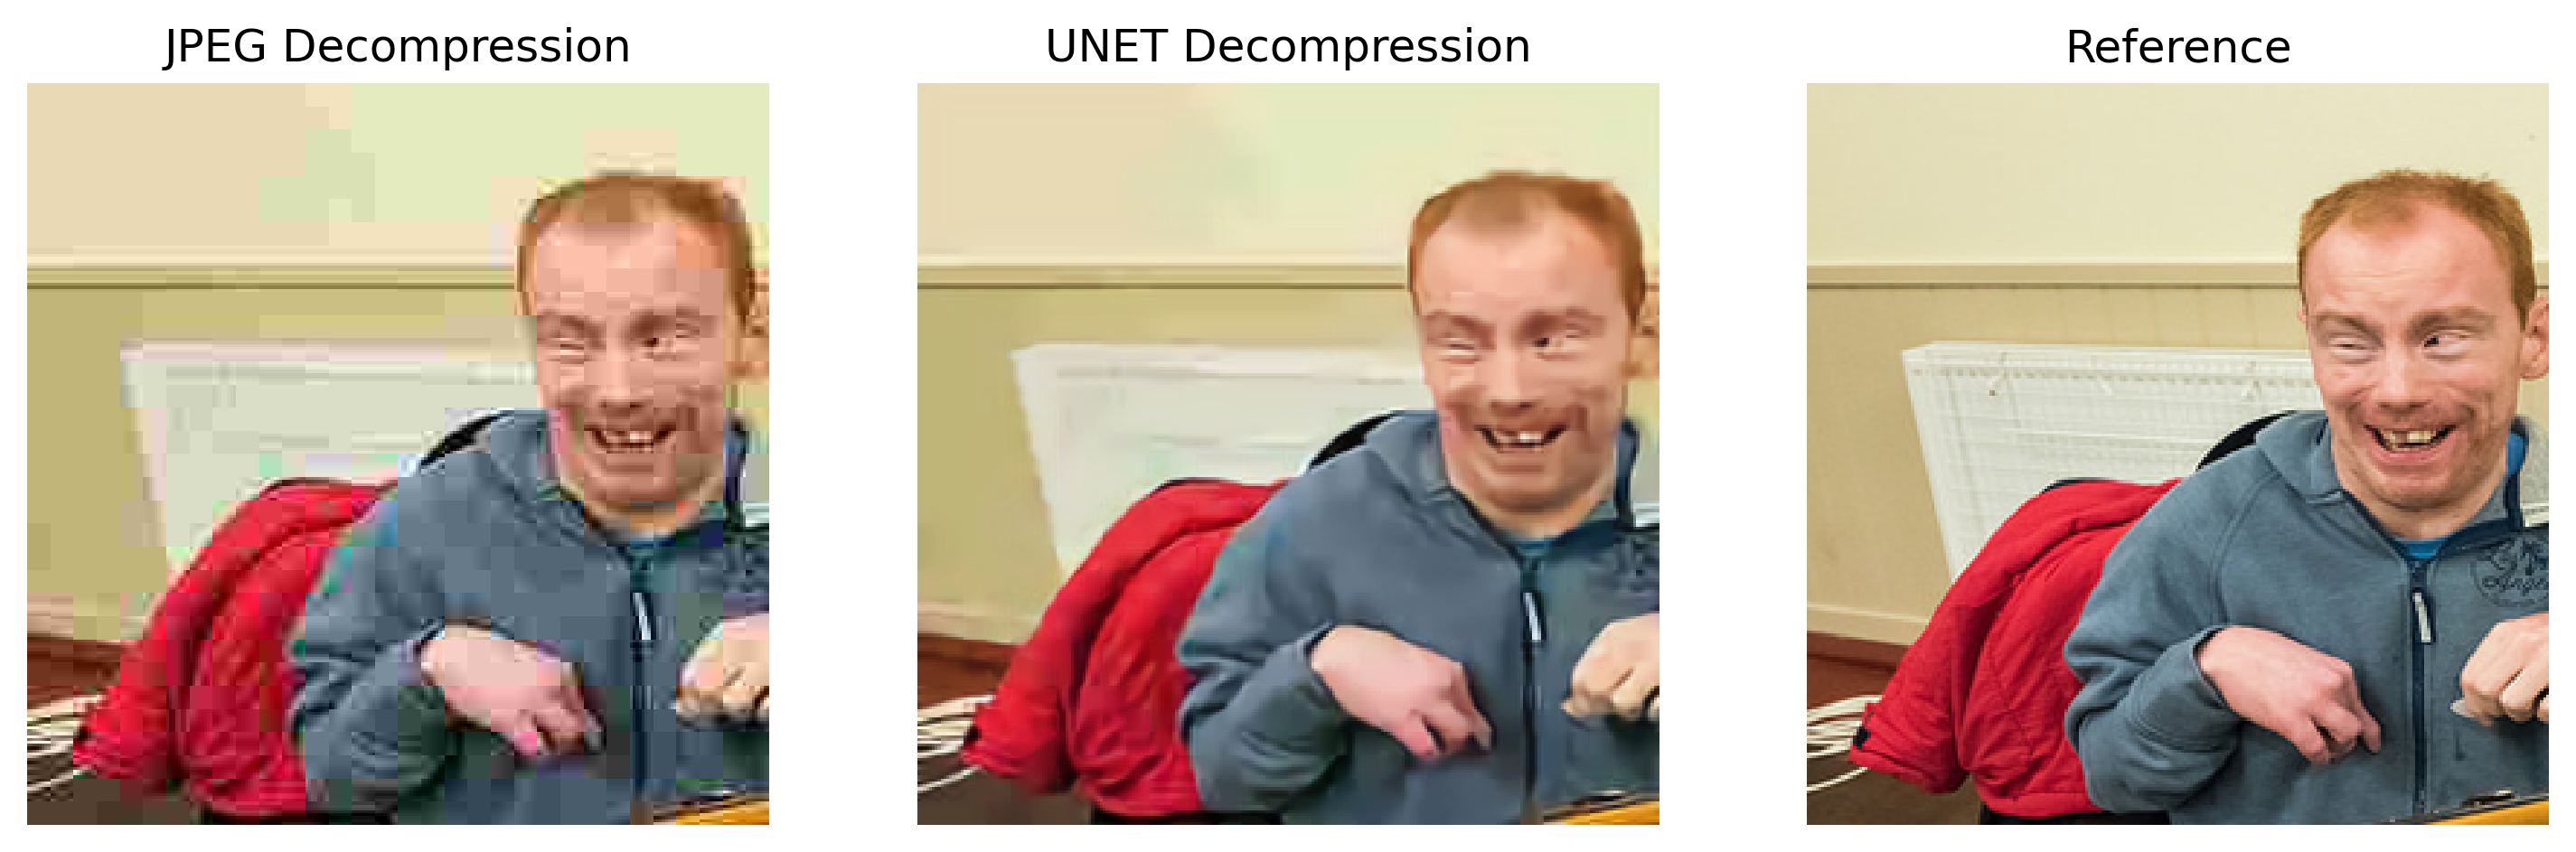

In [13]:
for ii in range(5):
    plt.figure(figsize = (12,4),dpi = 300)
    plt.subplot(1,3,1)
    plt.imshow(X_test[ii])
    plt.axis("off")
    plt.title("JPEG Decompression")
    plt.subplot(1,3,2)
    plt.imshow(Ypred[ii])
    plt.axis("off")
    plt.title("UNET Decompression")
    plt.subplot(1,3,3)
    plt.imshow(Y_test[ii])
    plt.axis("off")
    plt.title("Reference")
    plt.show()
    
    